In [173]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from keras.models import model_from_json

In [174]:
# load json and create model
json_file = open('ARCNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("ARCNN_weights_best.h5")
print("Loaded model from disk")

Loaded model from disk


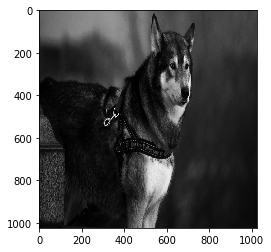

In [175]:
filenames = sorted(os.listdir('DIV2K_train_HR'))

block_size = 32
stride = 16
row_num = (1024 - block_size) // stride + 1
col_num = (1024 - block_size) // stride + 1


img = cv2.resize(cv2.imread('DIV2K_train_HR/'+filenames[54], 0),(1024,1024))
# cv2.imwrite('./predicted/dog_Label.png', img)
plt.imshow(img, cmap = 'gray')

In [176]:
compressed_files = sorted(os.listdir('compressed_new'))

block_size = 32
stride = 16

In [177]:
test_sample = cv2.resize(cv2.imread('compressed_new/'+compressed_files[54],0),(1024,1024))
# cv2.imwrite('./predicted/dog_Input.png', test_sample)
# plt.imshow(test_sample)
row_num = (test_sample.shape[0] - block_size) // stride + 1
col_num = (test_sample.shape[1] - block_size) // stride + 1

test_data = []
for y in range(row_num):
    for x in range(col_num):
        x_start = x*stride
        x_end = x_start+block_size
        y_start = y*stride
        y_end = y_start+block_size
        block = test_sample[y_start:y_end, x_start:x_end]
        test_data.append(loaded_model.predict(block.reshape(1,32,32,1)))
len(test_data)

3969

In [178]:
test_data = np.array(test_data).reshape(row_num,col_num,32,32,1)
print(test_data.shape)

(63, 63, 32, 32, 1)


(1024, 1024, 1)


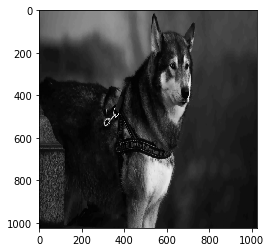

In [179]:
recon = np.ones((test_sample.shape[0],test_sample.shape[1],1))
for i in range(0,row_num):
    for j in range(0,col_num):
        if i%2 == 0 and j%2 == 0:
            recon[i*16:i*16+32,j*16:j*16+32] = test_data[i][j]

for i in range(0,row_num):
    for j in range(0,col_num):
        if i%2 != 0 and j%2 != 0:
            recon[i*16:i*16+32,j*16:j*16+32] = (recon[i*16:i*16+32,j*16:j*16+32] + test_data[i][j])/2

print(recon.shape)
# cv2.imwrite('./predicted/dog_Predicted.png', recon)
plt.imshow(recon.reshape(test_sample.shape[0],test_sample.shape[1]), cmap = 'gray') 

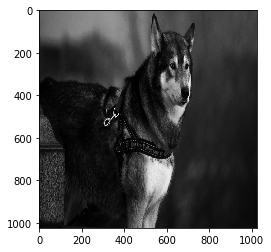

(1024, 1024, 1)


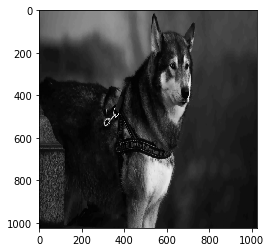

MSE:  9.576265335083008
MSE:  11.180781364440918

MAE (Y, X):  2.344008445739746
MAE (Y , Predict):  2.0651011638461396


In [182]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# plt.subplot(121)
plt.imshow(img, cmap = 'gray')
plt.show()
# plt.subplot(122)
print(recon.shape)
plt.imshow(recon.reshape(1024,1024), cmap = 'gray')
plt.show()
recon = np.array(recon)
err = np.sum((recon.astype("int") - img.reshape(img.shape[0],img.shape[1],1).astype("int")) ** 2)
err /= float(recon.shape[0] * recon.shape[1])
print("MSE: ",err)
err1 = np.sum((test_sample.astype("int") - img.reshape(img.shape[0],img.shape[1]).astype("int")) ** 2)
err1 /= float(recon.shape[0] * recon.shape[1])
print("MSE: ",err1)
# Compute MAE
print('\nMAE (Y, X): ', mean_absolute_error(img.reshape(img.shape[0],img.shape[1]).astype("int"), test_sample.astype("int")))
print('MAE (Y , Predict): ', mean_absolute_error(img.reshape(img.shape[0],img.shape[1]).astype("int"), recon.reshape(1024,1024)))

In [183]:
import math
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

print(psnr(recon, img.reshape(img.shape[0],img.shape[1],1)))
print(psnr(test_sample, img.reshape(img.shape[0],img.shape[1])))

38.51761802885255
37.974554046452184


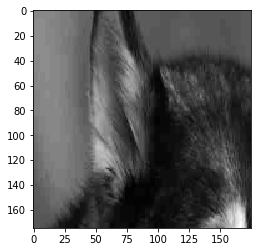

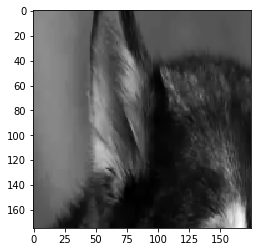

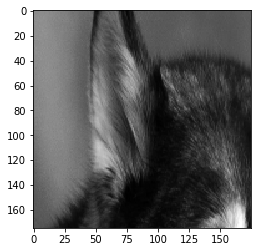

In [164]:
block_size = 175
stride = 16
y = 4
x = 30
x_start = x*stride
x_end = x_start+block_size
y_start = y*stride
y_end = y_start+block_size
input_block = test_sample[y_start:y_end, x_start:x_end]
# cv2.imwrite('./predicted/dog_input_patch.png', input_block)
label_block = img[y_start:y_end, x_start:x_end]
# cv2.imwrite('./predicted/dog_label_patch.png', label_block)
pred_block = recon[y_start:y_end, x_start:x_end]
# cv2.imwrite('./predicted/dog_pred_patch.png', pred_block)

plt.imshow(input_block, cmap = 'gray')
plt.figure()
plt.imshow(pred_block.reshape(block_size,block_size), cmap = 'gray')
plt.figure()
plt.imshow(label_block.reshape(block_size,block_size), cmap = 'gray')